In [1]:
import pandas as pd
import numpy as np
from gurobipy import *
from itertools import combinations
from scipy import sparse
import time
import matplotlib.pyplot as plt

In [3]:
# leer datos de minelib
# obtener funcion objetivo del .pcpsp, para comparar
# el resultado del modelo gurobi con el modelo AMPL
data_name = 'newman1'
pcpsp_path = '../minelib_inputs/' + data_name + '.pcpsp'
prec_path = '../minelib_inputs/' + data_name + '.prec'
upit_path = '../minelib_inputs/'+ data_name + '.upit'
objective_function_pcpsp = {}
resource_constraint_ub_limits = {}
resource_constraint_lb_limits = {}
resource_constraint_coefficients = {}
with open(pcpsp_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        if linea_lista[0] == 'NAME:':
            dato = linea_lista[1].strip('\n')
            name = dato
        elif linea_lista[0] == 'NBLOCKS:':
            dato = linea_lista[1].strip('\n')
            nblocks = int(dato)
        elif linea_lista[0] == 'NPERIODS:':
            dato = linea_lista[1].strip('\n')
            nperiods = int(dato)
        elif linea_lista[0] == 'NDESTINATIONS:':
            dato = linea_lista[1].strip('\n')
            ndestinations = int(dato)
        elif linea_lista[0] == 'NRESOURCE_SIDE_CONSTRAINTS:':
            dato = linea_lista[1].strip('\n')
            nresource_side_constraints = int(dato)
        elif linea_lista[0] == 'NGENERAL_SIDE_CONSTRAINTS:':
            dato = linea_lista[1].strip('\n')
            ngeneral_side_constraints = int(dato)
        elif linea_lista[0] == 'DISCOUNT_RATE:':
            dato = linea_lista[1].strip('\n')
            discount_rate = float(dato)
        elif linea_lista[0] == 'RESOURCE_CONSTRAINT_LIMITS:':
            for r in range(nresource_side_constraints):
                for t in range(nperiods):
                    linea = f.readline()
                    lista = linea.split()
                    if lista[2] == 'L':
                        resource_constraint_ub_limits[r,t] = int(lista[-1])
                        resource_constraint_lb_limits[r,t] = '-Infinity' # falta hacer para el caso general
                    else:
                        print('Este problema tiene cotas inferiores.')
                        break
        elif linea_lista[0] == 'OBJECTIVE_FUNCTION:':
            for b in range(nblocks):
                linea = f.readline()
                lista= linea.split()
                for d in range(ndestinations):
                    objective_function_pcpsp[b,d] = float(lista[d+1])
        elif linea_lista[0] == 'RESOURCE_CONSTRAINT_COEFFICIENTS:':
                for linea in f:
                    if linea == 'EOF\n':
                        break
                    lista = linea.split()
                    b = int(lista[0])
                    d = int(lista[1])
                    r = int(lista[2])
                    resource_constraint_coefficients[b,r,d] = float(lista[3])

# llenar con ceros las entradas de resource_constraint_coefficients
# que no está definidas
for b,r,d in itertools.product(range(nblocks), range(nresource_side_constraints),range(ndestinations)):
    if not (b,r,d) in resource_constraint_coefficients:
        resource_constraint_coefficients[b,r,d] = 0

# block value list para upit
bv_list = list() 
with open(upit_path, 'r') as f:
    for i in range(4):
        f.readline()
    for line in f:
        if not line == 'EOF\n':
            lista = line.split()
            bv_list.append(float(lista[1]))

print('Data base name: %s' % (name))
print('NBLOCKS: %d' % nblocks)
print('NPERIODS: %d' % nperiods)
print('NDESTINATIONS: %d' % ndestinations)
print('NRESOURCE_SIDE_CONSTRAINTS: %d' % nresource_side_constraints)
print('NGENERAL_SIDE_CONSTRAINTS: %d' % ngeneral_side_constraints)
print('DISCOUNT_RATE: %.2f' % discount_rate)

Data base name: Newman1
NBLOCKS: 1060
NPERIODS: 6
NDESTINATIONS: 2
NRESOURCE_SIDE_CONSTRAINTS: 2
NGENERAL_SIDE_CONSTRAINTS: 0
DISCOUNT_RATE: 0.08


In [13]:
# resolver upit
m = Model()
# variable de desicion para el modelo
x = {}
for i in range(nblocks):
    x[i] = m.addVar(vtype=GRB.BINARY, name = "x%d" % i)
m.update()
# definir objetivo
m.setObjective(LinExpr([bv_list[i]for i in range(nblocks)], [x[i] for i in range(nblocks)]), GRB.MAXIMIZE)
# definir restricciones
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        u = int(linea_lista[0])
        for j in range(nvecinos):
            v = int(linea_lista[j+2])
            m.addConstr(x[u] <= x[v])
m.optimize()
# recuperar upit
blocks_id_upit = [i for i in range(nblocks) if x[i].x==1] # recuperar upit
print('UPIT BLOCKS: %d' % len(blocks_id_upit))

Optimize a model with 3922 rows, 1060 columns and 7844 nonzeros
Variable types: 0 continuous, 1060 integer (1060 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 989307.55494
Found heuristic solution: objective 2.608690e+07
Presolve removed 3922 rows and 1060 columns
Presolve time: 0.03s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 2.60869e+07 989308 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.608689902597e+07, best bound 2.608689902597e+07, gap 0.0000%
UPIT BLOCKS: 1059


In [14]:
# funcion de reformulacion
# para PCP_at a PCP_by
def at_by_key(b,d,t):
    if d == 0 and t > 0:
        return b,ndestinations-1,t-1
    elif d > 0:
        return b,d-1,t
    elif d == 0 and t == 0:
        print('at_by_key no esta difinida para los valores d = %d, t = %d' % (d,t))
        
def check_optimality(sol,particion,ell,iteracion):
    for h in range(1,ell+1):
        for (b1,d1,t1),(b2,d2,t2) in combinations(particion[h,iteracion-1],2):
            if not np.isclose(sol[iteracion][b1,d1,t1].x,sol[iteracion][b2,d2,t2].x):
                return False
    return True

def check_opt_eff(sol, particion, ell, iteracion):#  quizas se mejor vectorizar el calculo de las sumas!!!
    for h in range(1,ell[iteracion-1]+1):
        if not (np.isclose(sum([sol[iteracion][b].x for b in particion[h,iteracion-1]]),0) or np.isclose(sum([sol[iteracion][b].x for b in particion[h,iteracion-1]]),len(particion[h,iteracion-1]))):
            return False
    return True

def check_opt_vect(sol, particion, ell, iteracion):
    for h in range(1,ell[iteracion-1]+1):
        arreglo = np.array([sol[iteracion][b].x for b in particion[h,iteracion-1]])
        summ = np.matmul(arreglo,np.ones(arreglo.shape))
        if not (np.isclose(summ,0) or np.isclose(summ,len(particion[h,iteracion-1]))):
            return False
    return True

In [5]:
blocks = blocks_id_upit
blockTimesDest = list(itertools.product(blocks,range(ndestinations)))
resourceTimesPeriod = list(itertools.product(list(range(nresource_side_constraints)),
                                             list(range(nperiods))))
blocks_prime = list(itertools.product(blocks, list(range(ndestinations)),list(range(nperiods))))

# crear un diccionario con los vecinos de cada bloque (precedencia espacial)
vecinos = {}
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            vecinos[a]=set()
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                vecinos[a].add(b)

In [9]:
# recalcular coeficientes de la funcion objetivo para PCP_by
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

c_hat = {}

for b,d,t in blocks_prime:
    if t==0 and d==0:
        c_hat[b,d,t] = -c[b,d,t]
    elif d<=ndestinations-2 and t>=1:
        c_hat[b,d,t] = c[b,d+1,t]
    elif d==ndestinations-1 and t<=nperiods-2:
        c_hat[b,d,t] = c[b,0,t+1]
    else:
        c_hat[b,d,t] = 0
    
cx2 = {}
for b,d,t in blocks_prime:
    if t==0:
        cx2[b,d,t] = -c_hat[b,d,0]
    else:
        cx2[b,d,t] = c[b,d,t]-c_hat[b,d,t]
cx2_array = np.array([cx2[b] for b in blocks_prime])
cx2_sparse = sparse.csr_matrix(cx2_array)

In [11]:
# BZ (original)

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo


# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
#cx_direct = quicksum([c[b,d,t]*(x[b,d,t]-x[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
#            +quicksum([c[b,0,t]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
#            +quicksum([c[b,0,0]*x[b,0,0] for b in blocks])
cx_direct = LinExpr([cx2[b] for b in blocks_prime],[x[b] for b in blocks_prime])
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
#problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
while True:
    if k==2:
        break
    # STEP 1: resolver L(PCPby,mu[k-1])
    suma = {}
    side_const = LinExpr()
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    fn_objetivo = cx_direct - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    problema_aux.Params.presolve = 0
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
    
    print('Determinar particion para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    
    model_p2k = Model()
    lmbda = {}
    init_dv = time.time()
    for i in range(1,eles[k]+1):
        lmbda[i] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)
    
    model_p2k.update()
    print('Definir lmbda y actualizar: %.2f[s]' % (time.time()-init_dv))
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        #x_lmbda[b] = quicksum([lmbda[h]*(b in C[h,k])for h in range(1,eles[k]+1)])
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    init_obj = time.time()
    cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
                +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
                +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    #cx_lmbda = LinExpr([c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b] for b in blocks_prime if b[1]>0 and b[2]>0])#+LinExpr([-c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b[0],b[1]-1,b[2]] for b in blocks_prime if b[1]>0 and b[2]>0])+LinExpr([c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([-c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],ndestinations-1,b[2]-1] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([c[b,0,0] for b in blocks],[x_lmbda[b,0,0] for b in blocks])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregamos las restricciones
    # para P2k con el cambio de variable
    # agregar restricciones de
    # precedencias.
    init_const = time.time()
    init_prec_1 = time.time()
    for t in range(nperiods-1):
        for b in blocks:
            model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])
    
    print('Agregar precedencias 1 : %.2f[s]' % (time.time()-init_prec_1))
    init_prec_2 = time.time()
    for d in range(ndestinations-1):
        for t in range(nperiods):
            for b in blocks:
                model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    print('Agregar precedencias 2: %.2f[s]' % (time.time()-init_prec_2))
    init_prec_3 = time.time()
    for a in blocks:
        for b in vecinos[a]:
            for t in range(nperiods):
                model_p2k.addConstr(x_lmbda[a,ndestinations-1,t] <= x_lmbda[b,ndestinations-1,t])
    
    print('Agregar precedencias 3: %.2f[s]' % (time.time()-init_prec_3))
    # agregar side constraints: si at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t]) for r,t in resourceTimesPeriod]):
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1


Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.11

Resolviendo problema auxiliar: k = 1
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimize a model with 35181 rows, 12708 columns and 70362 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.09 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 2312 iterations and 0.10 seconds
Optimal objective  2.613669784e+07
Resolver problema auxiliar tomo: 0.12[s]

Chequear optimalidad tomo: 0.00

Encontrar particion
Determinar particion para k = 1 tomo: 0.04

Construccion del modelo P2^k
Definir lmbda y actualizar: 0.00[s]
Proyectar variable en H^kx = 0 tomo: 0.06[s]
Calc

In [ ]:
# BZ vetorizado

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
cx_direct = quicksum([c[b,d,t]*(x[b,d,t]-x[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
            +quicksum([c[b,0,t]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
            +quicksum([c[b,0,0]*x[b,0,0] for b in blocks])
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
while True:
    # STEP 1: resolver L(PCPby,mu[k-1])
    suma = {}
    side_const = LinExpr()
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    fn_objetivo = cx_direct - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    problema_aux.Params.presolve = 0
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
    
    print('Determinar particion para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    
    model_p2k = Model()
    lmbda = {}
    init_dv = time.time()
    for i in range(1,eles[k]+1):
        lmbda[i] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)
    
    model_p2k.update()
    print('Definir lmbda y actualizar: %.2f[s]' % (time.time()-init_dv))
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        #x_lmbda[b] = quicksum([lmbda[h]*(b in C[h,k])for h in range(1,eles[k]+1)])
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    init_obj = time.time()
    cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
                +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
                +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    #cx_lmbda = LinExpr([c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b] for b in blocks_prime if b[1]>0 and b[2]>0])#+LinExpr([-c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b[0],b[1]-1,b[2]] for b in blocks_prime if b[1]>0 and b[2]>0])+LinExpr([c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([-c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],ndestinations-1,b[2]-1] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([c[b,0,0] for b in blocks],[x_lmbda[b,0,0] for b in blocks])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregamos las restricciones
    # para P2k con el cambio de variable
    # agregar restricciones de
    # precedencias.
    init_const = time.time()
    init_prec_1 = time.time()
    for t in range(nperiods-1):
        for b in blocks:
            model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])
    
    print('Agregar precedencias 1 : %.2f[s]' % (time.time()-init_prec_1))
    init_prec_2 = time.time()
    for d in range(ndestinations-1):
        for t in range(nperiods):
            for b in blocks:
                model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    print('Agregar precedencias 2: %.2f[s]' % (time.time()-init_prec_2))
    init_prec_3 = time.time()
    for a in blocks:
        for b in vecinos[a]:
            for t in range(nperiods):
                model_p2k.addConstr(x_lmbda[a,ndestinations-1,t] <= x_lmbda[b,ndestinations-1,t])
    
    print('Agregar precedencias 3: %.2f[s]' % (time.time()-init_prec_3))
    # agregar side constraints: si at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t],atol=1e-04) for r,t in resourceTimesPeriod]): # se relajo la tolerancia absoluta
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1


Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 5.93

Resolviendo problema auxiliar: k = 1
Resolver problema auxiliar tomo: 9.64[s]

Chequear optimalidad tomo: 0.00

Encontrar particion
Determinar particion para k = 1 tomo: 1.22

Construccion del modelo P2^k
Definir lmbda y actualizar: 0.00[s]
Proyectar variable en H^kx = 0 tomo: 1.47[s]
Calcular fn obj y actualizarla: 3.00[s]
Agregar precedencias 1 : 2.05[s]
Agregar precedencias 2: 2.16[s]
Agregar precedencias 3: 30.67[s]
Construir LinExpr para side const.: 4.78[s]
Agrergar side const.: 0.87[s]
Agregar restricciones: 40.55[s]

Construccion del modelo P2^k tomo:45.03[s]

Resolviendo master problem: k=1
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Resolver P2^k tomo:1.75[s]
Valor del problema maestro en iter k=1: 97975094.67

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[0] = mu[1]
Verificar mu[0] = mu[1] tomo: 0.00

Const

Proyectar variable en H^kx = 0 tomo: 3.48[s]
Calcular fn obj y actualizarla: 10.08[s]
Agregar precedencias 1 : 3.31[s]
Agregar precedencias 2: 4.89[s]
Agregar precedencias 3: 54.18[s]
Construir LinExpr para side const.: 9.67[s]
Agrergar side const.: 6.29[s]
Agregar restricciones: 78.59[s]

Construccion del modelo P2^k tomo:93.98[s]

Resolviendo master problem: k=9
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Resolver P2^k tomo:2.28[s]
Valor del problema maestro en iter k=9: 541215011.56

Recuperando variables duales
Recuperar variables duales tomo: 0.02

Verificar optimalidad: mu[8] = mu[9]
Verificar mu[8] = mu[9] tomo: 0.00

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 5.28

Resolviendo problema auxiliar: k = 10
Resolver problema auxiliar tomo: 9.89[s]

Chequear optimalidad tomo: 0.45

Encontrar particion
Determinar particion para k = 10 tomo: 1.41

Construccion del modelo P2^k
Definir lmbda y actualizar: 0.02[s]
Pr

Agregar precedencias 3: 183.60[s]
Construir LinExpr para side const.: 40.30[s]
Agrergar side const.: 37.83[s]
Agregar restricciones: 287.80[s]

Construccion del modelo P2^k tomo:354.07[s]

Resolviendo master problem: k=17
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Resolver P2^k tomo:7.28[s]
Valor del problema maestro en iter k=17: 810864355.27

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[16] = mu[17]
Verificar mu[16] = mu[17] tomo: 0.00

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 8.98

Resolviendo problema auxiliar: k = 18
Resolver problema auxiliar tomo: 155.19[s]

Chequear optimalidad tomo: 0.19

Encontrar particion
Determinar particion para k = 18 tomo: 2.70

Construccion del modelo P2^k
Definir lmbda y actualizar: 0.00[s]
Proyectar variable en H^kx = 0 tomo: 21.21[s]
Calcular fn obj y actualizarla: 68.43[s]
Agregar precedencias 1 : 15.96[s]
Agregar precedencia

Agrergar side const.: 388.09[s]
Agregar restricciones: 3433.58[s]

Construccion del modelo P2^k tomo:4497.17[s]

Resolviendo master problem: k=25
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Resolver P2^k tomo:50.38[s]
Valor del problema maestro en iter k=25: 861497569.37

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[24] = mu[25]
Verificar mu[24] = mu[25] tomo: 0.03

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 516.39

Resolviendo problema auxiliar: k = 26
Resolver problema auxiliar tomo: 32.39[s]

Chequear optimalidad tomo: 0.45

Encontrar particion
Determinar particion para k = 26 tomo: 11.42

Construccion del modelo P2^k
Definir lmbda y actualizar: 0.02[s]
Proyectar variable en H^kx = 0 tomo: 155.57[s]
Calcular fn obj y actualizarla: 1103.79[s]
Agregar precedencias 1 : 111.96[s]
Agregar precedencias 2: 99.47[s]
Agregar precedencias 3: 2522.00[s]


In [8]:
# BZ sin vectorizar, pero calculando base de H^kx=0 en cada iteracion
# para actualzar la funcion obj de p2^k

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo


# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
#cx_direct = quicksum([c[b,d,t]*(x[b,d,t]-x[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
#            +quicksum([c[b,0,t]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
#            +quicksum([c[b,0,0]*x[b,0,0] for b in blocks])
cx_direct = LinExpr([cx2[b] for b in blocks_prime],[x[b] for b in blocks_prime])
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
while True:
    # STEP 1: resolver L(PCPby,mu[k-1])
    if k==2:
        break
    suma = {}
    side_const = LinExpr()
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    fn_objetivo = cx_direct - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    problema_aux.Params.presolve = 0
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    base = {}
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
            base[count] = sparse.csr_matrix(np.zeros((len(blocks),1)))
            for row in C[count,k]:
                base[count][row,0] = 1
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
            base[count] = sparse.csr_matrix(np.zeros((len(blocks),1)))
            for row in C[count,k]:
                base[count][row,0] = 1
    
    print('Determinar particion para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    model_p2k = Model()
    lmbda = {}
    for i in range(1,eles[k]+1):
        lmbda[i] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)
    
    model_p2k.update()
    # construir base
    init_base = time.time()
    #base = {}
    #for b in blocks_prime:
    #    for h in range(1,1+eles[k]):
    #        base[h] = sparse.csr_matrix(np.array([((b,d,t) in C[h,k]) for b,d,t in blocks_prime])).T
    
    print('Construir base tomo: %.2f[s]' % (time.time()-init_base))
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        #x_lmbda[b] = quicksum([lmbda[h]*(b in C[h,k])for h in range(1,eles[k]+1)])
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    init_obj = time.time()
    #cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
    #            +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
    #            +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    #cx_lmbda = LinExpr([np.matmul(cx2_array,base[h]) for h in range(1,1+eles[k])],[lmbda[h] for h in range(1,1+eles[k])])
    prod = [cx2_sparse*base[h] for h in range(1,1+eles[k])]
    cx_lmbda = LinExpr([coeff.data[0] for coeff in prod],[lmbda[h] for h in range(1,1+eles[k])])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregamos las restricciones
    # para P2k con el cambio de variable
    # agregar restricciones de
    # precedencias.
    init_const = time.time()
    init_prec_1 = time.time()
    for t in range(nperiods-1):
        for b in blocks:
            model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])
    
    print('Agregar precedencias 1 : %.2f[s]' % (time.time()-init_prec_1))
    init_prec_2 = time.time()
    for d in range(ndestinations-1):
        for t in range(nperiods):
            for b in blocks:
                model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    print('Agregar precedencias 2: %.2f[s]' % (time.time()-init_prec_2))
    init_prec_3 = time.time()
    for a in blocks:
        for b in vecinos[a]:
            for t in range(nperiods):
                model_p2k.addConstr(x_lmbda[a,ndestinations-1,t] <= x_lmbda[b,ndestinations-1,t])
    
    print('Agregar precedencias 3: %.2f[s]' % (time.time()-init_prec_3))
    # agregar side constraints: si at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t]) for r,t in resourceTimesPeriod]):
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1


Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.12

Resolviendo problema auxiliar: k = 1
Resolver problema auxiliar tomo: 0.11[s]

Chequear optimalidad tomo: 0.00

Encontrar particion


C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


IndexError: index (1059) out of range (>= 1059)

In [16]:
len(blocks)

1059

In [22]:
78 in blocks

False

In [121]:
# definir listas utilies
blocks = blocks_id_upit
blockTimesDest = list(itertools.product(blocks,range(ndestinations)))
resourceTimesPeriod = list(itertools.product(list(range(nresource_side_constraints)),
                                             list(range(nperiods))))
blocks_prime = list(itertools.product(blocks, list(range(ndestinations)),list(range(nperiods))))

# matriz de precedencia temporal
n = len(blocks)
R = ndestinations
T = nperiods

rows= []
cols_plus = []
data= []
cols_minus = []
row = 0
for t in range(T-1):
    for b in blocks:
        rows.append(row) # revisar, quizas funciona de casualidad!!!
        cols_plus.append(b+(R-1)*n+t*R*n)
        data.append(1)
        cols_minus.append(b+(t+1)*R*n)        
        row+=1

M_plus =  sparse.csr_matrix((data,(rows,cols_plus)),shape=((T-1)*n,n*R*T))
M_minus =  sparse.csr_matrix(([-1 for data in data],(rows,cols_minus)),shape=((T-1)*n,n*R*T))
M = M_plus+M_minus
# matriz de precedencia en el destino
rows = []
cols_plus = []
cols_minus = []
data = []
row = 0
for t in range(T):
    for d in range(R-1):
        for b in blocks:
            rows.append(row)
            cols_plus.append(b + d*n + t*R*n)
            cols_minus.append(b + (d+1)*n + t*R*n)
            data.append(1)
            row +=1
            
ADplus = sparse.csr_matrix((data,(rows,cols_plus)),shape=(row,n*R*T))
ADminus = sparse.csr_matrix(([-1 for dato in data],(rows,cols_minus)),shape=(row,n*R*T))
AD = ADplus+ADminus
# matriz de precedencia espacial
rows = []
cols_plus = []
cols_minus = []
data = []
row = 0
for t in range(T):
    for b in blocks:
        for vecino in vecinos[a]:
            rows.append(row)
            cols_plus.append(b+(R-1)*n+t*R*n)
            cols_minus.append(vecino+(R-1)*n+t*R*n)
            data.append(1)
            row+=1
            
AEplus = sparse.csr_matrix((data,(rows,cols_plus)),shape=(row,n*R*T))
AEminus = sparse.csr_matrix(([-1 for dato in data],(rows,cols_minus)),shape=(row,n*R*T))
AE = AEplus + AEminus
# recalcualr coeff de fn objetivo
c_vec = {}
for (b,d,t) in blocks_prime:
    c_vec[b+d*n+2*t*n] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

# coeff. de las side constraints: a recalcular!!!
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits

ValueError: column index exceeds matrix dimensions

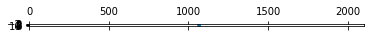

In [131]:
plt.spy(M[:10,:2100],markersize=1)

In [125]:
len(cols_minus)

6354

In [95]:
ind =  M.indices
s = ind[0]
e  = ind[0+1]
M.data[start:end]

array([], dtype=int32)

In [92]:
M.indptr

array([    0,     2,     4, ..., 10586, 10588, 10590], dtype=int32)

In [80]:
# BZ (original), pero sin usar una 3-tupla como indices
# solamente un vector

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo

V = range(len(blocks_prime))
# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for b,d,t in blocks_prime:
    x[b+n*d+t*R*n] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
    

problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for row in range(M.shape[0]):
    indptr = M.indptr
    start = indptr[row]
    end  = indptr[row+1]
    coeff = M.data[start:end+1]
    variables = [x[nodo] for nodo in M.indices[start:end+1]]
    problema_aux.addConstr(LinExpr(coeff,variables)<=0)

for row in range(AD.shape[0]):
    indptr = AD.indptr
    start = indptr[row]
    end  = indptr[row+1]
    coeff = AD.data[start:end+1]
    variables = [x[nodo] for nodo in AD.indices[start:end+1]]
    problema_aux.addConstr(LinExpr(coeff,variables)<=0)

# precedencia espacial
for row in range(AE.shape[0]):
    indptr = AE.indptr
    start = indptr[row]
    end  = indptr[row+1]
    coeff = AE.data[start:end+1]
    variables = [x[nodo] for nodo in AE.indices[start:end+1]]
    problema_aux.addConstr(LinExpr(coeff,variables)<=0)
    
# Funcion objetivo de L(PCP_by,mu[k-1])
Obj = LinExpr([c_vec[b+d*n+t*R*n] for b,d,t in blocks_prime],[x[b+d*n+t*R*n] for b,d,t in blocks_prime])


w = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
while True:
    if k==2:
        break
    # STEP 1: resolver L(PCPby,mu[k-1])
    #suma = {}
    #side_const = LinExpr()
    #LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    #for r in range(nresource_side_constraints):
    #    for t in range(nperiods):
    #        sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
    #        if t > 0:
    #            LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
    #        else:
    #            LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    fn_objetivo = Obj #- quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    problema_aux.Params.presolve = 0
    init_solve_aux = time.time()
    problema_aux.optimize()
    k+=1


Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.01

Resolviendo problema auxiliar: k = 1
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimize a model with 24357 rows, 12708 columns and 66696 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [5e+00, 1e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 12
 AA' NZ     : 1.101e+05
 Factor NZ  : 5.523e+05 (roughly 20 MBytes of memory)
 Factor Ops : 1.551e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.41962229e+09  4.13473038e+10  1.81e+00 1.77e+06  7.62e+06     0s
   1  -2.56048996e+09  3.58185208e+10  1.89e+00 3.45e+06  5.71e+06     0s
  

In [41]:
78 in AE.indices

True

In [ ]:
2.613669784e+07

In [14]:
# BZ (original), pero sin usar una 3-tupla como indices
# solamente un vector

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo

V = range(len(blocks_prime))
# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for nodo in V:
    x[nodo] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d)" % (nodo))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal

#for t in range(nperiods-1):
#    for b in blocks:
#        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
#cx_direct = quicksum([c[b,d,t]*(x[b,d,t]-x[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
#            +quicksum([c[b,0,t]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
#            +quicksum([c[b,0,0]*x[b,0,0] for b in blocks])
cx_direct = LinExpr([cx2[b] for b in blocks_prime],[x[b] for b in blocks_prime])
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
while True:
    # STEP 1: resolver L(PCPby,mu[k-1])
    suma = {}
    side_const = LinExpr()
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    fn_objetivo = cx_direct - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    problema_aux.Params.presolve = 0
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
    
    print('Determinar particion para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    
    model_p2k = Model()
    lmbda = {}
    init_dv = time.time()
    for i in range(1,eles[k]+1):
        lmbda[i] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)
    
    model_p2k.update()
    print('Definir lmbda y actualizar: %.2f[s]' % (time.time()-init_dv))
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        #x_lmbda[b] = quicksum([lmbda[h]*(b in C[h,k])for h in range(1,eles[k]+1)])
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    init_obj = time.time()
    cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
                +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
                +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    #cx_lmbda = LinExpr([c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b] for b in blocks_prime if b[1]>0 and b[2]>0])#+LinExpr([-c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b[0],b[1]-1,b[2]] for b in blocks_prime if b[1]>0 and b[2]>0])+LinExpr([c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([-c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],ndestinations-1,b[2]-1] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([c[b,0,0] for b in blocks],[x_lmbda[b,0,0] for b in blocks])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregamos las restricciones
    # para P2k con el cambio de variable
    # agregar restricciones de
    # precedencias.
    init_const = time.time()
    init_prec_1 = time.time()
    for t in range(nperiods-1):
        for b in blocks:
            model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])
    
    print('Agregar precedencias 1 : %.2f[s]' % (time.time()-init_prec_1))
    init_prec_2 = time.time()
    for d in range(ndestinations-1):
        for t in range(nperiods):
            for b in blocks:
                model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    print('Agregar precedencias 2: %.2f[s]' % (time.time()-init_prec_2))
    init_prec_3 = time.time()
    for a in blocks:
        for b in vecinos[a]:
            for t in range(nperiods):
                model_p2k.addConstr(x_lmbda[a,ndestinations-1,t] <= x_lmbda[b,ndestinations-1,t])
    
    print('Agregar precedencias 3: %.2f[s]' % (time.time()-init_prec_3))
    # agregar side constraints: si at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t]) for r,t in resourceTimesPeriod]):
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1

<1059x1 sparse matrix of type '<class 'numpy.float64'>'
	with 595 stored elements in Compressed Sparse Row format>

In [15]:
len(C[1,1])

10499

In [33]:
prod_csr = cx2_sparse*base[1].data[0]
prod_csr

<1x12708 sparse matrix of type '<class 'numpy.float64'>'
	with 12708 stored elements in Compressed Sparse Row format>

In [16]:
mu[13]

{(0, 0): 0.0,
 (0, 1): 0.04802917639449128,
 (0, 2): 0.0,
 (0, 3): 0.0,
 (0, 4): 0.0,
 (0, 5): 0.0,
 (1, 0): 0.9960963174438977,
 (1, 1): 1.0703763582284744,
 (1, 2): 0.5212304362190575,
 (1, 3): 0.0,
 (1, 4): 0.0,
 (1, 5): 0.0}

In [29]:
I = [ block for block in blocks_prime if w[k][block].x == 1]
O = [ block for block in blocks_prime if w[k][block].x == 0]
len(C[4,k-1].intersection(O))

86

In [44]:
eles[k-1]

3

In [84]:
for h in range(1,eles[k-1]+1):
    print('C[%d,%d] tiene size: %d' % (h,k-1,len(C[h,k-1])))
for h in range(1,eles[k-1]+1):
    print('Para C[%d,%d] los ws[%d] suman: %f' % (h,k-1,k,sum([w[k][b].x for b in C[h,k-1]])))

C[1,7] tiene size: 9041
C[2,7] tiene size: 234
C[3,7] tiene size: 990
C[4,7] tiene size: 50
C[5,7] tiene size: 24
C[6,7] tiene size: 50
C[7,7] tiene size: 24
C[8,7] tiene size: 86
C[9,7] tiene size: 12
C[10,7] tiene size: 8
C[11,7] tiene size: 46
C[12,7] tiene size: 2
C[13,7] tiene size: 2141
Para C[1,7] los ws[8] suman: 9041.000000
Para C[2,7] los ws[8] suman: 234.000000
Para C[3,7] los ws[8] suman: 990.000000
Para C[4,7] los ws[8] suman: 50.000000
Para C[5,7] los ws[8] suman: 24.000000
Para C[6,7] los ws[8] suman: 50.000000
Para C[7,7] los ws[8] suman: 0.000000
Para C[8,7] los ws[8] suman: 0.000000
Para C[9,7] los ws[8] suman: 12.000000
Para C[10,7] los ws[8] suman: 0.000000
Para C[11,7] los ws[8] suman: 0.000000
Para C[12,7] los ws[8] suman: 2.000000
Para C[13,7] los ws[8] suman: 0.000000


In [85]:
len(blocks_prime)

12708

In [87]:
sum([len(C[h,k-1]) for h in range(1,eles[k-1]+1)])

12708

In [64]:
ell = eles[4]
count = 1
for h in range(1,ell+1):
    d = 0 
    if C[h,3].intersection(I):
        C[count,4] = C[h,3].intersection(I)
        d = 1
    if C[h,3].intersection(O):
        if d == 0:
            C[count,4] = C[h,3].intersection(O)
            count += 1
        else:
            C[count+1,4] = C[h,3].intersection(O)
            count += 2
ell_dps = count-1

In [67]:
eles[4]

6

In [71]:
len(C[6,4])

2141

In [27]:
k

5

In [39]:
var_back = {}
for (b,d,t) in blocks_prime:
    var_back[b,d,t] = sum(lmbda[j].x*((b,d,t) in C[j,k-1]) for j in range(1,l+1))
opt = sum([c[b,d,t]*(var_back[b,d,t]-var_back[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
            +sum([c[b,0,t]*(var_back[b,0,t]-var_back[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
            +sum([c[b,0,0]*var_back[b,0,0] for b in blocks])
print('OPT de BZ: %.2f' % opt)

OPT de BZ: 8663560.30


In [ ]:
mu[1]

In [12]:
valor = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
	            +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
	            +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])


<gurobi.LinExpr: -33773.67209259259 lambda1 + -0.0 lambda2 + 33773.67209259259 lambda1 + 0.0 lambda2 + -31271.918604252398 lambda1 + -0.0 lambda2 + 31271.918604252398 lambda1 + 0.0 lambda2 + -28955.480189122583 lambda1 + -0.0 lambda2 + 28955.480189122583 lambda1 + 0.0 lambda2 + -26810.62980474313 lambda1 + -0.0 lambda2 + 26810.62980474313 lambda1 + 0.0 lambda2 + -24824.65722661401 lambda1 + -0.0 lambda2 + 24824.65722661401 lambda1 + 0.0 lambda2 + 22989.92222222222 lambda1 + 0.0 lambda2 + -0.0 lambda1 + -22989.92222222222 lambda2 + 21286.965020576128 lambda1 + 0.0 lambda2 + -21286.965020576128 lambda1 + -0.0 lambda2 + 19710.152796829745 lambda1 + 0.0 lambda2 + -19710.152796829745 lambda1 + -0.0 lambda2 + 18250.14147854606 lambda1 + 0.0 lambda2 + -18250.14147854606 lambda1 + -0.0 lambda2 + 16898.279146801906 lambda1 + 0.0 lambda2 + -16898.279146801906 lambda1 + -0.0 lambda2 + 31802.975 lambda1 + 0.0 lambda2 + -0.0 lambda1 + -31802.975 lambda2 + 29447.199074074073 lambda1 + 0.0 lambda2 + 

In [33]:
z[k] = {}
for (b,d,t) in blocks_prime:
	    	z[k][b,d,t] = sum(lmbda[j].x*((b,d,t) in C[j,k-1]) for j in range(1,l+1))

In [14]:
t0 = time.time()
for h in range(1,l+1):
    for (b1,d1,t1) in C[h,k-1]:
        for (b2,d2,t2) in C[h,k-1]:
            pass
print(time.time()-t0)

8.293293237686157


In [15]:
t0 = time.time()
for h in range(1,l+1):
    for (b1,d1,t1),(b2,d2,t2) in combinations(C[h,k-1],2):
        pass
print(time.time()-t0)

8.261805057525635


In [17]:
for tupla in combinations(set([2,1,4,5,67,7]),2):
    print(tupla)

(1, 2)
(1, 67)
(1, 4)
(1, 5)
(1, 7)
(2, 67)
(2, 4)
(2, 5)
(2, 7)
(67, 4)
(67, 5)
(67, 7)
(4, 5)
(4, 7)
(5, 7)


In [8]:
z[k] = {}
for (b,d,t) in blocks_prime:
    z[k][b,d,t] = sum(lmbda[j].x*((b,d,t) in C[j,k-1]) for j in range(1,l+1))
    
z[k].values

<function dict.values>

In [12]:
model_p2k.ObjVal*(1/obj_scale)

8663560.298788792

In [46]:
# calculo alternativo de las expresiones
# para ver si mejora el escalamiento numerico
cx_direct = quicksum([c[b,d,t]*(x[b,d,t]-x[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
            +quicksum([c[b,0,t]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
            +quicksum([c[b,0,0]*x[b,0,0] for b in blocks])
LHS = {}
for r in range(nresource_side_constraints):
    for t in range(nperiods):
        sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
        if t > 0:
            LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
        else:
            LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])

True

In [24]:
max(q.values())

5664.0